In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [7]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [8]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement

Station = Base.classes.station

In [9]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

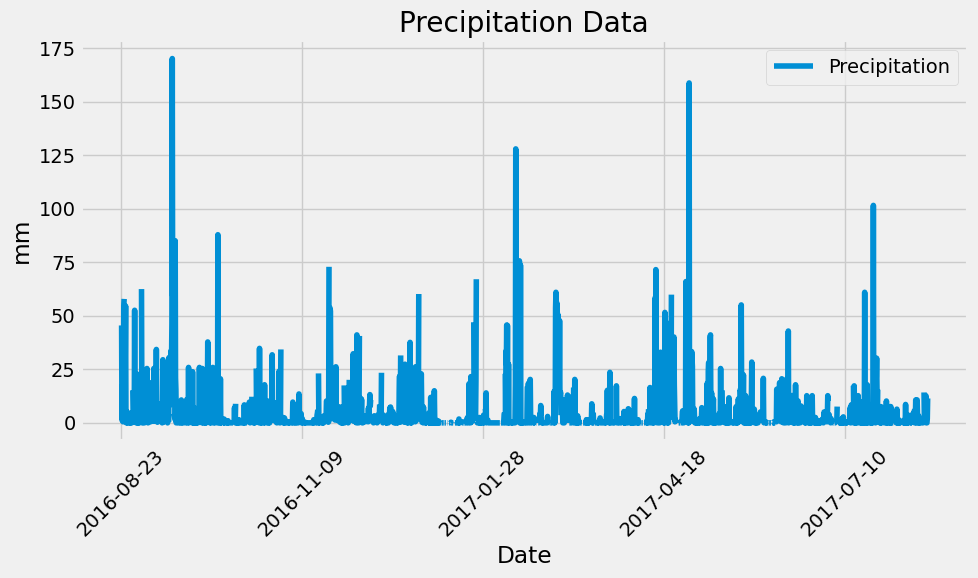

In [21]:
import datetime as dt
from datetime import datetime, timedelta
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date one year from the last date in data set.

#Converting the most recent date string to a datetime object
most_recent_date = datetime.strptime(most_recent_date.date, '%Y-%m-%d').date()

year_prior = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= year_prior, Measurement.date <= most_recent_date)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df_sorted = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df_sorted.plot(x='Date', y='Precipitation', figsize=(10,6))
plt.title('Precipitation Data')
plt.xlabel('Date')
plt.ylabel('mm')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

In [22]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df_sorted['Precipitation'].describe()
print(summary_stats)

count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [25]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc())\
.all()

for station,count in active_stations:
    print({station}, {count})

{'USC00519281'} {2772}
{'USC00519397'} {2724}
{'USC00513117'} {2709}
{'USC00519523'} {2669}
{'USC00516128'} {2612}
{'USC00514830'} {2202}
{'USC00511918'} {1979}
{'USC00517948'} {1372}
{'USC00518838'} {511}


In [27]:
most_active_station = active_stations[0][0]
print(most_active_station)

USC00519281


In [28]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#most active station is top of the list of active stations, 1st item is row 0 and station id is 1st column (column 0)
most_active_station = active_stations[0][0]

most_active_station_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
.filter(Measurement.station == most_active_station)\
.all()

print(most_active_station_data)

[(12.2, 29.4, 22.03582251082252)]


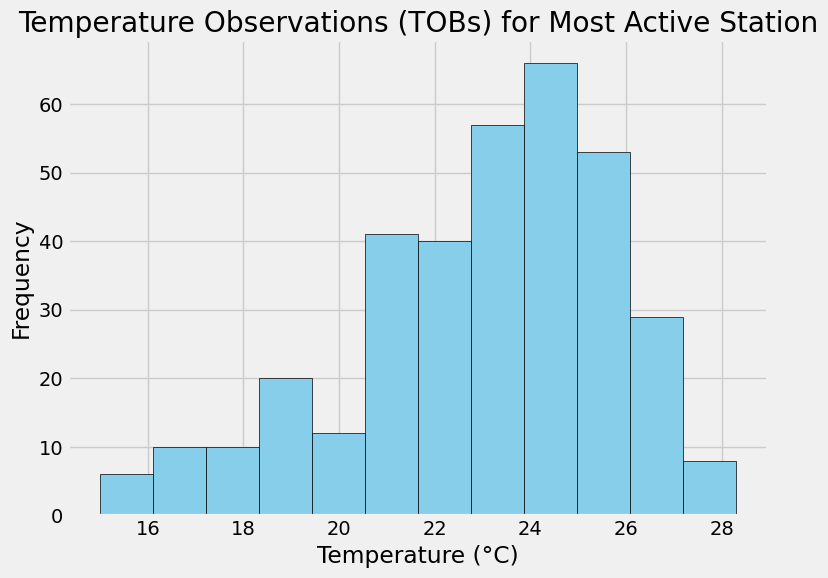

In [29]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#setting up the query with the dates previously found in the precipitation section
station_data = session.query(Measurement.tobs)\
    .filter(Measurement.date >= year_prior, Measurement.date <= most_recent_date)\
    .filter(Measurement.station == most_active_station)\
    .all()

station_df = pd.DataFrame(station_data, columns=['Temperature'])

#plotting the results in a histogram

plt.figure(figsize=(8, 6))
plt.hist(station_df['Temperature'], bins=12, color='skyblue', edgecolor='black')
plt.title('Temperatures for Most Active Station')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()



# Close Session

In [30]:
# Close Session
session.close()
